### Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

### Select folder with notebook. A data folder to contain the samples should be visible

In [ ]:
### for go up directory
%cd ..
### to go to directory
%cd ./gdrive/My Drive/Colab Notebooks
%ls

### Download the datasets and unzip into data folder

In [ ]:
!wget "https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/test.zip"

In [ ]:
!unzip '/gdrive/My Drive/Colab Notebooks/test.zip' -d '/gdrive/My Drive/Colab Notebooks/data/'

In [ ]:
!wget "https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/train.zip"

In [ ]:
!unzip '/gdrive/My Drive/Colab Notebooks/train.zip' -d '/gdrive/My Drive/Colab Notebooks/data/'

In [ ]:
!wget "https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/valid.zip"

In [ ]:
!unzip '/gdrive/My Drive/Colab Notebooks/valid.zip' -d '/gdrive/My Drive/Colab Notebooks/data/'

# change KERNEL to torch_py37
### Import the necessary librairies and count available samples

In [1]:
import numpy as np
import os
import sys
import time
from glob import glob
import pandas as pd
from PIL import Image, ImageFile
from collections import OrderedDict
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from tqdm import tnrange
from collections import OrderedDict

import torch
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
from pytorch_model_summary import summary  # upgraded version of torchsummary

### Set the device as CUDA or CPU

In [2]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if use_cuda:
    print('Default GPU Device: {}'.format(torch.cuda.get_device_name(0)))
else:
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')

Default GPU Device: GeForce RTX 2060


### Explore the data

There are 3644 total train images.
There are 150 total validation images.
There are 600 total test images.


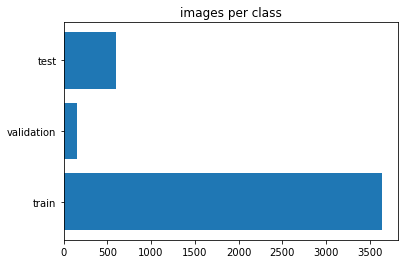

In [3]:
# load filenames for images
train_files = []
valid_files = []
test_files = []
files = ['train_files', 'valid_files', 'test_files']
mypath = os.getcwd()

for file in files:
    folder = file.split('_')[0]
    path = os.path.join(mypath, 'data', folder)

    for dir_ in os.listdir(path):
        subpath=os.path.join(path, dir_)
        if folder == 'train':
            train_files.extend(glob(subpath+'/*'))
        elif folder == 'valid':
            valid_files.extend(glob(subpath+'/*'))
        else:
            test_files.extend(glob(subpath+'/*'))
            
# print number of images in each dataset
print('There are %d total train images.' % len(train_files))
print('There are %d total validation images.' % len(valid_files))
print('There are %d total test images.' % len(test_files))

plt.barh(['train', 'validation', 'test'], [len(train_files), len(valid_files), len(test_files)])
plt.title('images per class')
plt.show()

### Display a few of the samples

\data\train\melanoma\ISIC_0000013.jpg 	img shape: (767, 1022, 3) 	min/max: [13 18 16] [255 255 255]
\data\train\melanoma\ISIC_0000022.jpg 	img shape: (1129, 1504, 3) 	min/max: [0 0 0] [255 255 255]
\data\train\melanoma\ISIC_0000026.jpg 	img shape: (1129, 1504, 3) 	min/max: [0 0 0] [255 255 255]


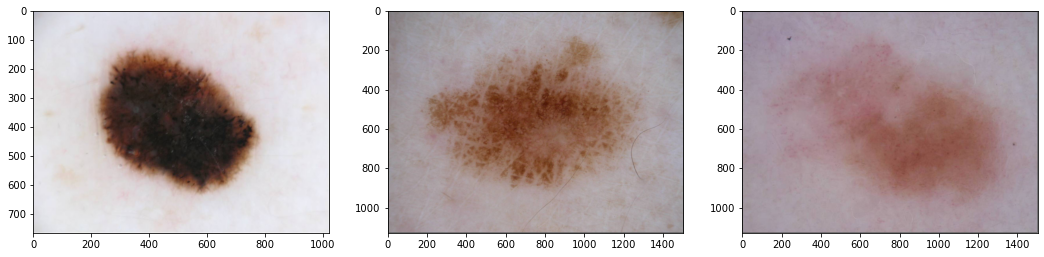

In [4]:
import cv2                
import matplotlib.pyplot as plt                           

plt.figure(figsize=(18,9))
for index, img_path in enumerate(train_files[:3]):
    plt.subplot(1,3, index+1)
    # images are within [0,255] and must be scaled to [0,1] for pytorch pretrained models
    img = cv2.imread(img_path)
    print(img_path.split('dermatologist-ai-master')[1], '\timg shape:', img.shape, '\tmin/max:', img.min(axis=(0,1)), img.max(axis=(0,1)))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
plt.show()

In [5]:
# determine smallest image dimensions in Train dataset
h_min = 10000
w_min = 10000

for img_path in tqdm(train_files):
    img = cv2.imread(img_path)
    h, w, _ = img.shape
    if h < h_min:
        h_min = h
    if w < w_min:
        w_min = w

print('smallest dimensions in train dataset h x w: ', h_min,' x ', w_min)


smallest dimensions in train dataset h x w:  450  x  576


 ### DATA AUGMENTATION - train dataset is squewed towards Nevus
- dataset augmented using ISIC database
    - 165 additional Seborrheic Keratosis images
    - 998 additional melanoma images
- data augmentation performed on Seborrheic Keratosis to balance the dataset between classes

train set: number of  melanoma  images:  1342
train set: number of  nevus  images:  1129
train set: number of  seborrheic_keratosis  images:  1173


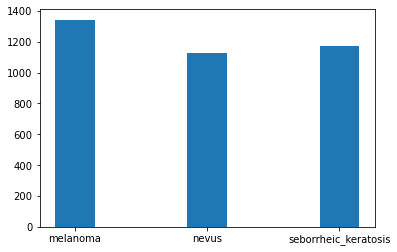

In [5]:
labels=['melanoma', 'nevus', 'seborrheic_keratosis']
counts=np.zeros(3).astype(np.int)
for index, label in enumerate(labels):
    path = os.path.join(mypath, 'data', 'train', label)
    counts[index] = len(os.listdir(path))
    print('train set: number of ',label,' images: ',counts[index])

plt.bar(labels, counts, width = 0.3)
plt.ylim(bottom=0)
plt.show()

# Data augmentation to balance under-represented classes
# RUN ONCE ONLY

In [234]:
from PIL import Image

path = os.path.join(mypath, 'data', 'train', 'seborrheic_keratosis')
list_of_imgs = os.listdir(path)
counth = 0
countv = 0
for index, file in enumerate(tqdm(list_of_imgs)):
    file_name = os.path.join(path,file)
    image = Image.open(file_name)
    
    # flip up-down using np.flipud
    up_down = image.transpose(method=Image.FLIP_TOP_BOTTOM)
    up_down.save(os.path.join(path,'imageflipV{}.jpeg'.format(index)), 'JPEG')
    countv+=1
    
    # flip up-down using np.flipud
    left_right = image.transpose(method=Image.FLIP_LEFT_RIGHT)
    left_right.save(os.path.join(path,'imageflipH{}.jpeg'.format(index)), 'JPEG')
    counth+=1
print('Images generated and saved to disk: {} Horizontal flip, {} vertical flip...{} images in total'.format(counth, countv, counth+countv))


Images generated and saved to disk: 417 Horizontal flip, 417 vertical flip...834 images in total


# END DATA AUGMENTATION

train set: number of  melanoma  images:  1342
train set: number of  nevus  images:  1129
train set: number of  seborrheic_keratosis  images:  1173


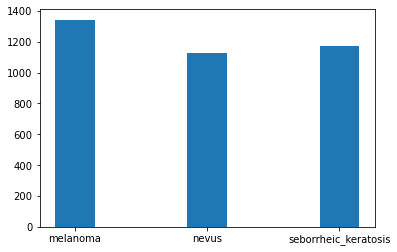

In [6]:
# Train dataset post image augmentation
labels=['melanoma', 'nevus', 'seborrheic_keratosis']
counts=np.zeros(3).astype(np.int)
for index, label in enumerate(labels):
    path = os.path.join(mypath, 'data', 'train', label)
    counts[index] = len(os.listdir(path))
    print('train set: number of ',label,' images: ',counts[index])

plt.bar(labels, counts, width = 0.3)
plt.ylim(bottom=0)
plt.show()

In [8]:
# Let's calculate corrective weights to apply during training
# Calculate corrective weights for class imbalance
counts = counts.astype(np.float)
median_freq=np.median(counts)
class_weights=np.zeros_like(labels, dtype=np.float)
print('Corrective weights to account for dataset over-representation of Nevus')
for index, label in enumerate(labels):
    class_weights[index]=median_freq / counts[index]
    print(label,' : ',class_weights[index])

class_weights = torch.FloatTensor(class_weights)
if use_cuda:
    class_weights = class_weights.cuda()

Corrective weights to account for dataset over-representation of Nevus
melanoma  :  0.8740685543964233
nevus  :  1.0389725420726306
seborrheic_keratosis  :  1.0


### Set dataloader with appropriate image transformations. I use data augmentation

In [7]:
# Pytorch default backend for images are Pillow. when using ToTensor(), PyTorch automatically converts all images into [0,1]

def get_loaders (input_shape, batch_size_train, batch_size_val, batch_size_test, num_workers):
    
    data_dir = 'data/'
    train_dir = os.path.join(data_dir, 'train/')
    valid_dir = os.path.join(data_dir, 'valid/')
    test_dir = os.path.join(data_dir, 'test/')
    (img_dim_H,img_dim_W) = input_shape

    train_transform = transforms.Compose([transforms.Resize((img_dim_H,img_dim_W)),                                               
                                        transforms.RandomHorizontalFlip(0.5),
                                        transforms.RandomVerticalFlip(0.5),
                                        transforms.RandomRotation(45),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                                            std=(0.229, 0.224, 0.225))])  
    
    valid_transform = transforms.Compose([transforms.Resize((img_dim_H,img_dim_W)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                                            std=(0.229, 0.224, 0.225))])

    test_transform = transforms.Compose([transforms.Resize((img_dim_H,img_dim_W)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                                          std=(0.229, 0.224, 0.225))])

    train_data = datasets.ImageFolder(train_dir, transform=train_transform)
    valid_data = datasets.ImageFolder(valid_dir, transform=valid_transform)
    test_data = datasets.ImageFolder(test_dir, transform=test_transform)

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size_train, shuffle=True, num_workers=num_workers)
    valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size_val, shuffle=True, num_workers=num_workers)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test, shuffle=False, num_workers=num_workers)

    return {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

### (IMPLEMENTATION) Train and Validate the Model


In [8]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, file_name, is_inception=False):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    running_train_loss = []
    running_val_loss = []
    start_time = time.time()
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        av_loss_train = 0
        av_loss_val = 0
        
        previous_time = time.time()
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            optimizer.zero_grad()

            if is_inception:
              output, aux_output = model(data)
              loss1 = criterion(output, target)
              loss2 = criterion(aux_output, target)
              loss = loss1 + 0.4 * loss2                 # 0.4 is weight for auxillary classifier in Inception V3
            else:
              output = model(data)
              loss = criterion(output, target)

            loss.backward()
            optimizer.step()
            
            ## record the average training loss
            #train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.item() - train_loss))
            train_loss += loss.item() * len(target)
            av_loss_train = train_loss / ((batch_idx+1) * batch_size_train)
            
            # Get training statistics.
            current_time = time.time()
            stats = 'Epoch [%d/%d] Step [%d/%d]\t Loss: %.4f\t avg_Loss: %.4f\t exec_time: %d s\t train_time:\t %d h %d m' % (epoch, n_epochs, batch_idx+1, len(loaders['train']), loss.item(), av_loss_train, #train_loss,
                    (current_time - previous_time), (current_time-start_time)//3600, (current_time-start_time)//60-((current_time-start_time)//3600)*60)
            
            # Print training statistics (on same line).
            print('\r' + stats, end="")
            sys.stdout.flush()

            # Print training statistics (on different line).
            if (batch_idx+1) % print_every == 0:
                print('\r' + stats)
        
        ######################    
        # validate the model #
        ######################
        model.eval()
        dataset_size = 0
        running_corrects = 0
        
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            with torch.no_grad():
                output = model(data)
                loss = criterion(output, target)
                #valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.item() - valid_loss))
                valid_loss += loss.item() * target.size(0)
                av_loss_val = valid_loss / ((batch_idx+1) * batch_size_val)
            
                _, preds = torch.max(output, 1)
                running_corrects += torch.sum(preds == target.data)
                dataset_size += len(data)
        
        accuracy = torch.true_divide(running_corrects, dataset_size) * 100
        #batch_loss = train_loss / len(loaders['train'].dataset)
        # Get training/validation statistics        
        stats = 'Epoch [%d/%d]\t avg_train Loss: %.4f\t\t\t avg_validation Loss: %.4f\t val_accuracy: %.2f' % (epoch, n_epochs, av_loss_train, av_loss_val, accuracy)   # valid_loss,
            
        # Print validation statistics (on new line).
        print(stats)
        sys.stdout.flush()
        
        # store losses for later use
        running_train_loss.append(av_loss_train)  #train_loss
        running_val_loss.append(av_loss_val)    #valid_loss
        
        ## Save the model if validation loss has decreased
        if av_loss_val < valid_loss_min:
            valid_loss_min = av_loss_val
            save_file = os.path.join(save_path, file_name)
            torch.save(model.state_dict(), save_file)
            print('improved model saved to disk')
        
        
        #if valid_loss < valid_loss_min:
        #    valid_loss_min = valid_loss
            
        
        scheduler.step(valid_loss)
            
    # return trained model
    return model, running_train_loss, running_val_loss

In [9]:
### Calculate the accuracy
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    
    class_correct = list(0. for i in range(num_classes))
    class_total = list(0. for i in range(num_classes))

    model.eval()
    
    for batch_idx, (data, targets) in enumerate(tqdm(loaders['test'])):
        # move to GPU
        if use_cuda:
            data, targets = data.cuda(), targets.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(data)
        # calculate the loss
        loss = criterion(outputs, targets).item()
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss - test_loss))
        
        # convert output probabilities to predicted class
        output = torch.nn.functional.softmax(outputs, dim=1)
        _, preds = torch.max(output, dim=1)
        
        # compare predictions to true label
        correct_tensor = preds.eq(targets.view_as(preds))    # equivalent to tensor.view(preds.size())
        correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
        
        # calculate test accuracy for each object class
        for i in range(batch_size_test):
            label = targets[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
            
    print('Test Loss: {:.6f}\n'.format(test_loss))
    
    for i in range(num_classes):
        if class_total[i] > 0:
            
            print('Test Accuracy of {}:'.format(labels[i]),
              ' {:.0f}%'.format(100 * class_correct[i] / class_total[i]).ljust(8,' '), 
              '({:.0f}/{:.0f})'.format(np.sum(class_correct[i]), np.sum(class_total[i])))
            
        else:
            print('Test Accuracy of {}: N/A (no training examples)'.format(labels[i]))
                      
    print('\nTest Accuracy (Overall):\t {:.0f}%'.format(100. * np.sum(class_correct) / np.sum(class_total)).expandtabs(71),
      '\t({:.0f}/{:.0f})'.format(np.sum(class_correct), np.sum(class_total)).expandtabs(4))

In [10]:
def plot_loss(model, train_loss, val_loss):
    plt.plot(np.arange(1, n_epochs+1,1), train_loss, label='average train loss')
    plt.plot(np.arange(1, n_epochs+1,1), val_loss, label='average validation loss')
    plt.xlabel('epochs')
    plt.ylabel('running losses')
    plt.title('loss reduction ' + model)
    plt.legend(loc='upper right')
    filename = 'loss_reduction_profile_'+model+'.png'
    plt.savefig(filename)
    plt.show()

## Display example of inherence output format for get_results.py (performance evaluation)

In [13]:
true_labels = pd.read_csv("ground_truth.csv", sep=",", header=0, index_col=0)
print(list(true_labels))
true_labels.head(5)

['task_1', 'task_2']


,task_1,task_2
Id,,
data/test/melanoma/ISIC_0012258.jpg,1,0
data/test/melanoma/ISIC_0012356.jpg,1,0
data/test/melanoma/ISIC_0012369.jpg,1,0
data/test/melanoma/ISIC_0012395.jpg,1,0
data/test/melanoma/ISIC_0012425.jpg,1,0


## Get predictions and prepare results file

In [11]:
def test_transform_img(img, input_img_dim):
    test_transform = transforms.Compose([transforms.Resize((input_img_dim[0],input_img_dim[1])),
                                      #transforms.CenterCrop((input_img_dim[0],input_img_dim[1])),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                                          std=(0.229, 0.224, 0.225))
                                        ])
    return test_transform(img)

def get_image(img_path, input_img_dim):
    image = Image.open(img_path)
    image = test_transform_img(image, input_img_dim)
    image = image.requires_grad_(True)
    #image = torch.tensor(image, requires_grad=True)
    image = image.unsqueeze(0)                         # add batch dimension
    return image

In [12]:
def get_predictions(model, path_to_files, input_img_dim=(224,224)):
    if use_cuda:
        model = model.cuda()
    model.eval()
    score_1 = []
    score_2 = []
    for img_path in tqdm(path_to_files):
        img = get_image(img_path, input_img_dim)
        if use_cuda:
            img = img.cuda()
        pred = model(img).cpu().detach().numpy()
        score_1.append(float(pred[0][0]))
        score_2.append(float(pred[0][2]))
    return score_1, score_2 

In [13]:
import csv
    
def get_scores(model, input_img_dim):
    
    print("\ngetting predictions on all test images:")
    score_1, score_2 = get_predictions(model, test_files, input_img_dim)
    
    print("writing score csv file")
    with open('results.csv', 'w', newline='') as csvfile:
        doc = csv.writer(csvfile)
        doc.writerow(['Id', 'task_1', 'task_2'])
        for i in range(len(test_files)):
            doc.writerow([test_files[i], score_1[i], score_2[i]])
        
    plot_scores()

### Evaluate predictions and Plot scores

In [14]:
import sys
import itertools
import get_results as results

def plot_scores():
    
    threshold = 0.5 

    # get ground truth labels for test dataset
    truth = pd.read_csv('ground_truth.csv')
    y_true = truth[["task_1", "task_2"]].values

    # get model predictions for test dataset
    y_pred = pd.read_csv('results.csv')
    y_pred = y_pred[["task_1", "task_2"]].values

    # plot ROC curves and print scores
    results.plot_roc_auc(y_true, y_pred)
    
    # plot confusion matrix
    classes = ['benign', 'malignant']
    results.plot_confusion_matrix(y_true[:,0], y_pred[:,0], threshold, classes)

# (IMPLEMENTATION) Model Architecture
---
In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html).  

# Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  
You are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).

In [446]:
#from torchsummary import summary          # original version torchsummary
from pytorch_model_summary import summary  # upgraded version of torchsummary

num_classes = 3                            # melanoma, nevus, keratosis

## Specify model architecture 
model_VGG = models.vgg16(pretrained=True)

for param in model_VGG.features.parameters():                     # freeze feature parameters of pre-trained VGG16 model
    param.requires_grad = False

model_VGG.classifier[6] = nn.Linear(4096, num_classes)   # replace last layer with proper output dimensions

# Print summary and move to GPU/CPU
if use_cuda:
    model_VGG = model_VGG.cuda()
    summary(model_VGG, torch.zeros((1, 3, 224, 224)).to(device), show_input=False, show_hierarchical=False, print_summary=True)
else:
    summary(model_VGG, torch.zeros((1, 3, 224, 224)), show_input=False, show_hierarchical=False, print_summary=True)

-------------------------------------------------------------------------------
           Layer (type)           Output Shape         Param #     Tr. Param #
               Conv2d-1      [1, 64, 224, 224]           1,792               0
                 ReLU-2      [1, 64, 224, 224]               0               0
               Conv2d-3      [1, 64, 224, 224]          36,928               0
                 ReLU-4      [1, 64, 224, 224]               0               0
            MaxPool2d-5      [1, 64, 112, 112]               0               0
               Conv2d-6     [1, 128, 112, 112]          73,856               0
                 ReLU-7     [1, 128, 112, 112]               0               0
               Conv2d-8     [1, 128, 112, 112]         147,584               0
                 ReLU-9     [1, 128, 112, 112]               0               0
           MaxPool2d-10       [1, 128, 56, 56]               0               0
              Conv2d-11       [1, 256, 56, 56]     

### (IMPLEMENTATION) Specify Loss Function and Optimizer


In [21]:
image_size = (350,450)  # max(450,576)
num_workers = 0
batch_size_train = 10
batch_size_val = 10
batch_size_test = 10
loaders=get_loaders(image_size, batch_size_train, batch_size_val, batch_size_test, num_workers)

In [12]:
criterion = nn.CrossEntropyLoss()     # In Pytorch, CrossEntropyLoss combines a Logsoftmax with a NLLLoss
optimizer = optim.Adam(model_VGG.classifier.parameters(), lr=0.00001, betas=(0.9,0.999))
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

In [22]:
# train the model
n_epochs = 10
print_every = 317
save_path = './models'

model_VGG, train_loss, val_loss = train(n_epochs, loaders, model_VGG, optimizer, criterion, use_cuda, 'model_VGG_fine3.pt', is_inception=False)

Epoch [1/10] Step [315/316]	 Loss: 0.3890	 avg_Loss: 0.5901	 exec_time: 469 s	 train_time:	 0 h 7 mEpoch [1/10]	 avg_train Loss: 0.5901			 avg_validation Loss: 0.6198 
improved model saved to disk
Epoch [2/10] Step [315/316]	 Loss: 0.4758	 avg_Loss: 0.5965	 exec_time: 501 s	 train_time:	 0 h 16 mEpoch [2/10]	 avg_train Loss: 0.5965			 avg_validation Loss: 0.6205 
Epoch [3/10] Step [315/316]	 Loss: 0.4301	 avg_Loss: 0.5866	 exec_time: 508 s	 train_time:	 0 h 25 mEpoch [3/10]	 avg_train Loss: 0.5866			 avg_validation Loss: 0.6179 
improved model saved to disk
Epoch [4/10] Step [315/316]	 Loss: 0.7511	 avg_Loss: 0.5795	 exec_time: 498 s	 train_time:	 0 h 34 mEpoch [4/10]	 avg_train Loss: 0.5795			 avg_validation Loss: 0.6158 
improved model saved to disk
Epoch [5/10] Step [315/316]	 Loss: 0.4864	 avg_Loss: 0.5845	 exec_time: 508 s	 train_time:	 0 h 43 mEpoch [5/10]	 avg_train Loss: 0.5845			 avg_validation Loss: 0.6149 
improved model saved to disk
Epoch [6/10] Step [315/316]	 Loss: 0.312

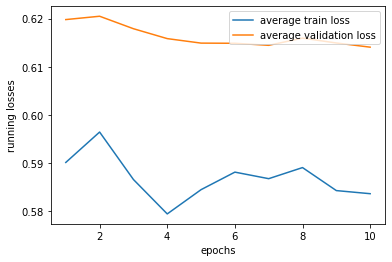

In [23]:
# Display loss reduction profile
plot_loss('VGG16', train_loss, val_loss)

### (IMPLEMENTATION) Test the Model

Calculate and print the test loss and accuracy.

In [453]:
# load the model that got the best validation accuracy (uncomment the line below)
if torch.cuda.is_available():
    model_VGG.load_state_dict(torch.load('models/model_VGG.pt'))
else:
    model_VGG.load_state_dict(torch.load('models/model_VGG.pt', map_location=torch.device('cpu')))


Test Loss: 0.937992

Test Accuracy of melanoma:  50%     (58/117)
Test Accuracy of nevus:  54%     (213/393)
Test Accuracy of seborrheic_keratosis:  47%     (42/90)

Test Accuracy (Overall):                                                52%     (313/600)

getting predictions on all test images:



writing score csv file


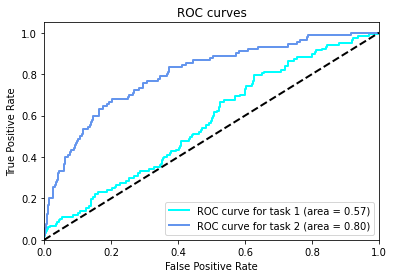

Category 1 Score: 0.568
Category 2 Score: 0.801
Category 3 Score: 0.684


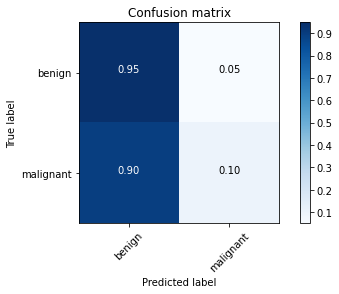

In [454]:
with torch.no_grad():
    test(loaders, model_VGG, criterion, use_cuda)
    get_scores(model_VGG, (450,576))

# Obtain Pre-trained Inception V3 Model
The code cell below downloads the model, along with weights that have been trained on ImageNet, a very large, very popular dataset used for image classification and other vision tasks. ImageNet contains over 10 million URLs, each linking to an image containing an object from one of 1000 categories.

In [543]:
## Specify model architecture 
num_classes = 3

model_inception = models.inception_v3(pretrained=True, aux_logits=True)             # Be careful, InceptionV3 expects (299,299) sized images and has auxiliary output

model_inception = model_inception.to(device)

### Modify both output layers of Inception model for the classification task
- aux_ouput
- fully connected layer

In [565]:
def count_parameters(model):
    total_params = 0
    #for index, parameter in enumerate(model.parameters()):
    for index, (name, parameter) in enumerate(model.named_parameters()):
        #if not parameter.requires_grad: continue
        param = parameter.numel()
        print('weight n°',index, '\tlayer:', name, '\t\t#parameters ', param)
        total_params+=param
    print(f"\nTotal Trainable Params: {total_params}")

In [544]:
#for param in model_inception.parameters():               # freeze feature parameters of pre-trained VGG16 model
#    param.requires_grad = False
    
for param in model_inception.parameters():               # freeze feature parameters of pre-trained VGG16 model
    param.requires_grad = False


model_inception.AuxLogits.fc = nn.Linear(768, num_classes)

BasicConv2d = nn.Sequential(OrderedDict([('conv', nn.Conv2d(2048, 192, kernel_size=(1,1), stride=(1,1))),
                                         ('bn', nn.BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True))]))

classifier = nn.Sequential(OrderedDict([ ('fc1', nn.Linear(2048, 512)),     
                                         ('relu', nn.ReLU()),
                                        ('drop', nn.Dropout(0.4)),
                                         ('fc2', nn.Linear(512, num_classes)) 
                                         ]))                                                # ('output', nn.Softmax(dim=1))

model_inception.Mixed_7c.branch_pool = BasicConv2d
model_inception.fc = classifier

print(summary(model_inception.to(device), torch.zeros((1, 3, 299, 299)).to(device), show_input=False, show_hierarchical=False, print_summary=False))

#for module, layer in model_inception.named_modules():
#    print(module, layer)

------------------------------------------------------------------------------
           Layer (type)          Output Shape         Param #     Tr. Param #
          BasicConv2d-1     [1, 32, 149, 149]             928               0
          BasicConv2d-2     [1, 32, 147, 147]           9,280               0
          BasicConv2d-3     [1, 64, 147, 147]          18,560               0
            MaxPool2d-4       [1, 64, 73, 73]               0               0
          BasicConv2d-5       [1, 80, 73, 73]           5,280               0
          BasicConv2d-6      [1, 192, 71, 71]         138,624               0
            MaxPool2d-7      [1, 192, 35, 35]               0               0
           InceptionA-8      [1, 256, 35, 35]         255,904               0
           InceptionA-9      [1, 288, 35, 35]         277,472               0
          InceptionA-10      [1, 288, 35, 35]         285,152               0
          InceptionB-11      [1, 768, 17, 17]       1,153,280  

In [566]:
count_parameters(model_inception)

weight n° 0 	layer: Conv2d_1a_3x3.conv.weight 		#parameters  864
weight n° 1 	layer: Conv2d_1a_3x3.bn.weight 		#parameters  32
weight n° 2 	layer: Conv2d_1a_3x3.bn.bias 		#parameters  32
weight n° 3 	layer: Conv2d_2a_3x3.conv.weight 		#parameters  9216
weight n° 4 	layer: Conv2d_2a_3x3.bn.weight 		#parameters  32
weight n° 5 	layer: Conv2d_2a_3x3.bn.bias 		#parameters  32
weight n° 6 	layer: Conv2d_2b_3x3.conv.weight 		#parameters  18432
weight n° 7 	layer: Conv2d_2b_3x3.bn.weight 		#parameters  64
weight n° 8 	layer: Conv2d_2b_3x3.bn.bias 		#parameters  64
weight n° 9 	layer: Conv2d_3b_1x1.conv.weight 		#parameters  5120
weight n° 10 	layer: Conv2d_3b_1x1.bn.weight 		#parameters  80
weight n° 11 	layer: Conv2d_3b_1x1.bn.bias 		#parameters  80
weight n° 12 	layer: Conv2d_4a_3x3.conv.weight 		#parameters  138240
weight n° 13 	layer: Conv2d_4a_3x3.bn.weight 		#parameters  192
weight n° 14 	layer: Conv2d_4a_3x3.bn.bias 		#parameters  192
weight n° 15 	layer: Mixed_5b.branch1x1.conv.weight

In [95]:
for module, layer in model_inception.named_modules():
    parse_module = module.split('.')
    sub_level=True
    if len(parse_module)==1:
        if sub_level:
            print(module, end='')
            sub_level=False
        else:
            print()
            print(module)
            #sub_level=True
    
    if len(parse_module)==2:
        if parse_module[1]=='conv':
            print('...', parse_module[1], '> ', end='')
        elif parse_module[1]=='bn':
            print(parse_module[1])
            sub_level=False
        elif sub_level:
            print('...', parse_module[1], end='')
            sub_level=False
        else:
            print()
            print('...', parse_module[1])
            sub_level = True
                
    if len(parse_module)==3:
        if parse_module[2]=='conv':
            print('...', parse_module[2], '> ', end='')
        elif parse_module[2]=='bn':
            print(parse_module[2])
            sub_level=False
        else:
            print('...........', parse_module[2])
            

Conv2d_1a_3x3... conv > bn
Conv2d_2a_3x3... conv > bn
Conv2d_2b_3x3... conv > bn
maxpool1Conv2d_3b_1x1... conv > bn
Conv2d_4a_3x3... conv > bn
maxpool2Mixed_5b... branch1x1  conv  > bn
... branch5x5_1  conv  > bn
... branch5x5_2  conv  > bn
... branch3x3dbl_1  conv  > bn
... branch3x3dbl_2  conv  > bn
... branch3x3dbl_3  conv  > bn
... branch_pool  conv  > bn
Mixed_5c... branch1x1  conv  > bn
... branch5x5_1  conv  > bn
... branch5x5_2  conv  > bn
... branch3x3dbl_1  conv  > bn
... branch3x3dbl_2  conv  > bn
... branch3x3dbl_3  conv  > bn
... branch_pool  conv  > bn
Mixed_5d... branch1x1  conv  > bn
... branch5x5_1  conv  > bn
... branch5x5_2  conv  > bn
... branch3x3dbl_1  conv  > bn
... branch3x3dbl_2  conv  > bn
... branch3x3dbl_3  conv  > bn
... branch_pool  conv  > bn
Mixed_6a... branch3x3  conv  > bn
... branch3x3dbl_1  conv  > bn
... branch3x3dbl_2  conv  > bn
... branch3x3dbl_3  conv  > bn
Mixed_6b... branch1x1  conv  > bn
... branch7x7_1  conv  > bn
... branch7x7_2  conv  > bn

In [545]:
# Instantiate dataloaders
image_size = (299,299)  # max(450,576)
num_workers = 1
batch_size_train = 64
batch_size_val = 10
batch_size_test = 10
loaders=get_loaders(image_size, batch_size_train, batch_size_val, batch_size_test, num_workers)

In [514]:
dataiter = iter(loaders['train'])
images, true_labels = dataiter.next()
print(images.shape, true_labels.shape)

torch.Size([64, 3, 299, 299]) torch.Size([64])


In [550]:
# Define training parameters
criterion = nn.CrossEntropyLoss()
#criterion = nn.CrossEntropyLoss(weight=class_weights)        
params_to_update = [{'params': model_inception.Mixed_7c.branch_pool.parameters()}, {'params': model_inception.AuxLogits.fc.parameters()}, {'params': model_inception.fc.parameters()}] 
optimizer = optim.Adam(params_to_update, lr=0.000001, betas=(0.9,0.999))
#optimizer = optim.RMSprop(params_to_update, lr=0.0001)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.66)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

In [547]:
# train the model
n_epochs = 4
print_every = 57
save_path = './models'

model_inception, train_loss, val_loss = train(n_epochs, loaders, model_inception, optimizer, criterion, use_cuda, 'model_inception_fine.pt', is_inception=True)

Epoch [1/4] Step [57/57]	 Loss: 1.5856	 avg_Loss: 1.5561	 exec_time: 418 s	 train_time:	 0 h 6 m
Epoch [1/4]	 avg_train Loss: 1.5561			 avg_validation Loss: 1.0892	 val_accuracy: 42.00
improved model saved to disk
Epoch [2/4] Step [57/57]	 Loss: 1.5499	 avg_Loss: 1.5429	 exec_time: 421 s	 train_time:	 0 h 14 m
Epoch [2/4]	 avg_train Loss: 1.5429			 avg_validation Loss: 1.0908	 val_accuracy: 42.00
Epoch [3/4] Step [57/57]	 Loss: 1.5231	 avg_Loss: 1.5383	 exec_time: 421 s	 train_time:	 0 h 22 m
Epoch [3/4]	 avg_train Loss: 1.5383			 avg_validation Loss: 1.0913	 val_accuracy: 42.00
Epoch [4/4] Step [57/57]	 Loss: 1.4893	 avg_Loss: 1.5324	 exec_time: 420 s	 train_time:	 0 h 29 m
Epoch [4/4]	 avg_train Loss: 1.5324			 avg_validation Loss: 1.0930	 val_accuracy: 42.00


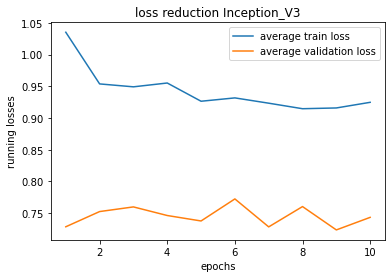

In [427]:
# Display loss reduction profile
plot_loss('Inception_V3', train_loss, val_loss)

In [563]:
# load the model that got the best validation accuracy
if torch.cuda.is_available():
    model_inception.load_state_dict(torch.load('models/model_inception.pt'))
else:
    model_inception.load_state_dict(torch.load('models/model_inception.pt', map_location=torch.device('cpu')))


Test Loss: 0.819266

Test Accuracy of melanoma:  33%     (39/117)
Test Accuracy of nevus:  84%     (329/393)
Test Accuracy of seborrheic_keratosis:  24%     (22/90)

Test Accuracy (Overall):                                                65%     (390/600)

getting predictions on all test images:



writing score csv file


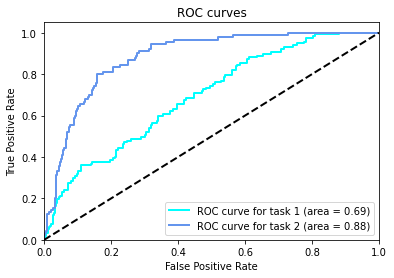

Category 1 Score: 0.693
Category 2 Score: 0.883
Category 3 Score: 0.788


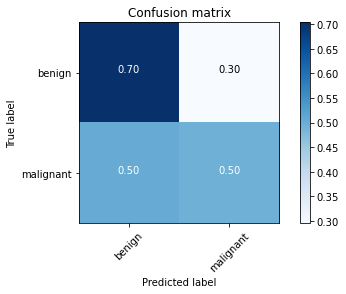

In [564]:
with torch.no_grad():
    test(loaders, model_inception, criterion, use_cuda)

get_scores(model_inception, (450,576))

### Best result achieved on GoogleColab with this version trained for 15 epochs - 86% accuracy

In [ ]:
num_classes = 3
model_inception = models.inception_v3(pretrained=True, aux_logits=True)             # Be careful, InceptionV3 expects (299,299) sized images and has auxiliary output
model_inception = model_inception.to(device)

for param in model_inception.parameters():             
    param.requires_grad = True

model_inception.AuxLogits.fc = nn.Linear(768, num_classes)
classifier = nn.Sequential(OrderedDict([ ('fc1', nn.Linear(2048, 1024)),     
                                         ('relu', nn.ReLU()),
                                        ('drop', nn.Dropout(0.1)),
                                         ('fc2', nn.Linear(1024, num_classes)) 
                                         ]))                                            
model_inception.fc = classifier
print(summary(model_inception.to(device), torch.zeros((1, 3, 299, 299)).to(device), show_input=False, show_hierarchical=False, print_summary=False))

In [ ]:
# Instantiate dataloaders
image_size = (299,299)  # max(450,576)
num_workers = 1
batch_size_train = 32
batch_size_val = 10
batch_size_test = 10
loaders=get_loaders(image_size, batch_size_train, batch_size_val, batch_size_test, num_workers)
# Define training parameters
criterion = nn.CrossEntropyLoss()
#criterion = nn.CrossEntropyLoss(weight=class_weights)        
params_to_update = [{'params': model_inception.parameters()}] 
optimizer = optim.Adam(params_to_update, lr=0.0001, betas=(0.9,0.999))
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

In [ ]:
# train the model
n_epochs = 15
print_every = 127
save_path = './models'

model_inception, train_loss, val_loss = train(n_epochs, loaders, model_inception, 
                                              optimizer, criterion, use_cuda, 'model_inception_3.pt', is_inception=True)

In [ ]:
# Display loss reduction profile
plot_loss('Inception_V3', train_loss, val_loss)

In [ ]:
# load the model that got the best validation accuracy
if torch.cuda.is_available():
    model_inception.load_state_dict(torch.load('models/model_inception_3.pt'))
else:
    model_inception.load_state_dict(torch.load('models/model_inception_3.pt', map_location=torch.device('cpu')))

In [ ]:
with torch.no_grad():
    test(loaders, model_inception, criterion, use_cuda)
    get_scores(model_inception, (450,576))

# Testing with ResNet152 pre-trained model

In [382]:
model_Resnet= models.resnet152(pretrained = True)

for param in model_Resnet.parameters():
    param.requires_grad = False
    
from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('Dropout-1',nn.Dropout(0.4)),
                          ('fc1', nn.Linear(2048, 3)),
                          ]))

model_Resnet.fc = classifier

if use_cuda:
    model_Resnet = model_Resnet.cuda()

print(summary(model_Resnet.to(device), torch.zeros((1, 3, 224, 224)).to(device), show_input=False, show_hierarchical=False, print_summary=False))

------------------------------------------------------------------------------
           Layer (type)          Output Shape         Param #     Tr. Param #
               Conv2d-1     [1, 64, 112, 112]           9,408               0
          BatchNorm2d-2     [1, 64, 112, 112]             128               0
                 ReLU-3     [1, 64, 112, 112]               0               0
            MaxPool2d-4       [1, 64, 56, 56]               0               0
           Bottleneck-5      [1, 256, 56, 56]          75,008               0
           Bottleneck-6      [1, 256, 56, 56]          70,400               0
           Bottleneck-7      [1, 256, 56, 56]          70,400               0
           Bottleneck-8      [1, 512, 28, 28]         379,392               0
           Bottleneck-9      [1, 512, 28, 28]         280,064               0
          Bottleneck-10      [1, 512, 28, 28]         280,064               0
          Bottleneck-11      [1, 512, 28, 28]         280,064  

Epoch [1/15] Step [368/368]	 Loss: 0.7945	 avg_Loss: 0.9627	 exec_time: 407 s	 train_time:	 0 h 6 m
Epoch [1/15]	 avg_train Loss: 0.9627			 avg_validation Loss: 0.7985	 accuracy: 61.33
improved model saved to disk
Epoch [2/15] Step [368/368]	 Loss: 1.1981	 avg_Loss: 0.8977	 exec_time: 410 s	 train_time:	 0 h 14 m
Epoch [2/15]	 avg_train Loss: 0.8977			 avg_validation Loss: 0.9903	 accuracy: 52.67
Epoch [3/15] Step [368/368]	 Loss: 0.8191	 avg_Loss: 0.8387	 exec_time: 411 s	 train_time:	 0 h 21 m
Epoch [3/15]	 avg_train Loss: 0.8387			 avg_validation Loss: 0.7132	 accuracy: 71.33
improved model saved to disk
Epoch [4/15] Step [368/368]	 Loss: 0.3165	 avg_Loss: 0.8659	 exec_time: 412 s	 train_time:	 0 h 28 m
Epoch [4/15]	 avg_train Loss: 0.8659			 avg_validation Loss: 0.7785	 accuracy: 72.67
Epoch [5/15] Step [368/368]	 Loss: 0.8709	 avg_Loss: 0.8892	 exec_time: 413 s	 train_time:	 0 h 36 m
Epoch [5/15]	 avg_train Loss: 0.8892			 avg_validation Loss: 0.7925	 accuracy: 67.33
Epoch [6/15] 

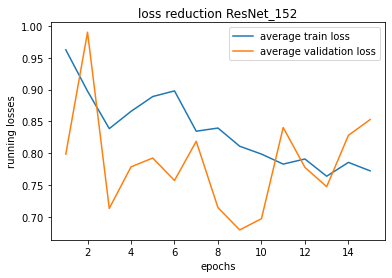

In [385]:
# Set up dataloaders
num_classes = 3
image_size = (224,224)  # max(450,576)
num_workers = 1
batch_size_train = 10
batch_size_val = 10
batch_size_test = 10
loaders=get_loaders(image_size, batch_size_train, batch_size_val, batch_size_test, num_workers)

# Define parameters
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model_Resnet.fc.parameters(), lr=0.0001)
optimizer = optim.SGD(model_Resnet.fc.parameters(), lr = 0.001, momentum = 0.91)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

# Train model
n_epochs = 15
print_every = 368
save_path = './models'
model_Resnet, train_loss, val_loss = train(n_epochs, loaders, model_Resnet, optimizer, criterion, use_cuda,
                                           'model_Resnet.pt', is_inception=False)

# Display loss reduction profile
plot_loss('ResNet_152', train_loss, val_loss)


Test Loss: 0.837614

Test Accuracy of melanoma:  36%     (42/117)
Test Accuracy of nevus:  68%     (269/393)
Test Accuracy of seborrheic_keratosis:  53%     (48/90)

Test Accuracy (Overall):                                                60%     (359/600)

getting predictions on all test images:



writing score csv file


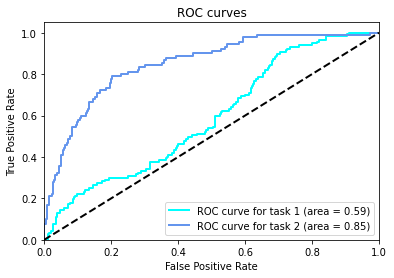

Category 1 Score: 0.590
Category 2 Score: 0.848
Category 3 Score: 0.719


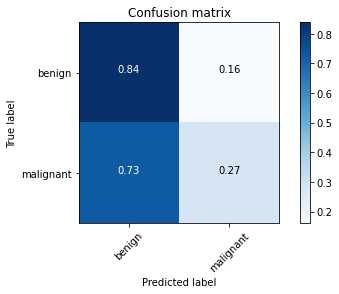

In [386]:
# load the model that got the best validation accuracy
if torch.cuda.is_available():
    model_Resnet.load_state_dict(torch.load('models/model_Resnet.pt'))
else:
    model_Resnet.load_state_dict(torch.load('models/model_Resnet.pt', map_location=torch.device('cpu')))

# Test model
with torch.no_grad():
    test(loaders, model_Resnet, criterion, use_cuda)

get_scores(model_Resnet, (450,576))

# Test ResNet50

In [15]:
model_Resnet50= models.resnet50(pretrained = True)

for param in model_Resnet50.parameters():
    param.requires_grad = True
    
from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 1024)),
                          ('Elu', nn.ELU()),
                          ('Dropout',nn.Dropout(0.05)),
                          ('fc2', nn.Linear(1024, 3)),
                          ]))

model_Resnet50.fc = classifier

if use_cuda:
    model_Resnet50 = model_Resnet50.cuda()

print(summary(model_Resnet50.to(device), torch.zeros((1, 3, 224, 224)).to(device), show_input=False, show_hierarchical=False, print_summary=False))

------------------------------------------------------------------------------
           Layer (type)          Output Shape         Param #     Tr. Param #
               Conv2d-1     [1, 64, 112, 112]           9,408           9,408
          BatchNorm2d-2     [1, 64, 112, 112]             128             128
                 ReLU-3     [1, 64, 112, 112]               0               0
            MaxPool2d-4       [1, 64, 56, 56]               0               0
           Bottleneck-5      [1, 256, 56, 56]          75,008          75,008
           Bottleneck-6      [1, 256, 56, 56]          70,400          70,400
           Bottleneck-7      [1, 256, 56, 56]          70,400          70,400
           Bottleneck-8      [1, 512, 28, 28]         379,392         379,392
           Bottleneck-9      [1, 512, 28, 28]         280,064         280,064
          Bottleneck-10      [1, 512, 28, 28]         280,064         280,064
          Bottleneck-11      [1, 512, 28, 28]         280,064  

Epoch [1/15] Step [365/365]	 Loss: 0.9679	 avg_Loss: 0.7500	 exec_time: 410 s	 train_time:	 0 h 6 m
Epoch [1/15]	 avg_train Loss: 0.7500			 avg_validation Loss: 0.8080	 val_accuracy: 70.00
improved model saved to disk
Epoch [2/15] Step [365/365]	 Loss: 0.3830	 avg_Loss: 0.6121	 exec_time: 438 s	 train_time:	 0 h 14 m
Epoch [2/15]	 avg_train Loss: 0.6121			 avg_validation Loss: 0.6576	 val_accuracy: 69.33
improved model saved to disk
Epoch [3/15] Step [365/365]	 Loss: 0.7509	 avg_Loss: 0.5697	 exec_time: 440 s	 train_time:	 0 h 22 m
Epoch [3/15]	 avg_train Loss: 0.5697			 avg_validation Loss: 0.7308	 val_accuracy: 70.00
Epoch [4/15] Step [365/365]	 Loss: 1.3105	 avg_Loss: 0.5304	 exec_time: 430 s	 train_time:	 0 h 30 m
Epoch [4/15]	 avg_train Loss: 0.5304			 avg_validation Loss: 0.5619	 val_accuracy: 78.00
improved model saved to disk
Epoch [5/15] Step [365/365]	 Loss: 0.2630	 avg_Loss: 0.4818	 exec_time: 417 s	 train_time:	 0 h 37 m
Epoch [5/15]	 avg_train Loss: 0.4818			 avg_validatio

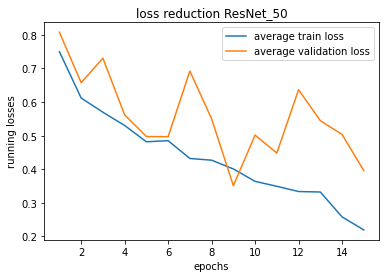

In [17]:
# Set up dataloaders
image_size = (224,224)  # max(450,576)
num_workers = 1
batch_size_train = 10
batch_size_val = 10
batch_size_test = 10
loaders=get_loaders(image_size, batch_size_train, batch_size_val, batch_size_test, num_workers)

# Define parameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_Resnet50.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Train model
n_epochs = 15
print_every = 365
save_path = './models'
model_Resnet50, train_loss, val_loss = train(n_epochs, loaders, model_Resnet50, optimizer, criterion, use_cuda,
                                           'model_Resnet50.pt', is_inception=False)

# Display loss reduction profile
plot_loss('ResNet_50', train_loss, val_loss)


Test Loss: 0.684818

Test Accuracy of melanoma:  65%     (76/117)
Test Accuracy of nevus:  71%     (279/393)
Test Accuracy of seborrheic_keratosis:  93%     (84/90)

Test Accuracy (Overall):                                                73%     (439/600)

getting predictions on all test images:



writing score csv file


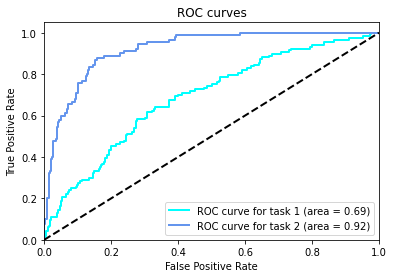

Category 1 Score: 0.687
Category 2 Score: 0.920
Category 3 Score: 0.803


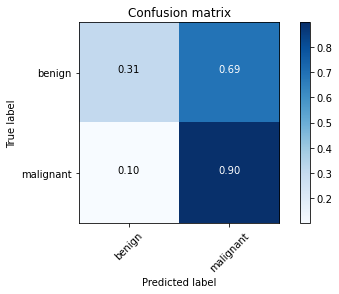

In [19]:
# load the model that got the best validation accuracy
if torch.cuda.is_available():
    model_Resnet50.load_state_dict(torch.load('models/model_Resnet50.pt'))
else:
    model_Resnet50.load_state_dict(torch.load('models/model_Resnet50.pt', map_location=torch.device('cpu')))

num_classes = 3

# Test model
with torch.no_grad():
    test(loaders, model_Resnet50, criterion, use_cuda)

    get_scores(model_Resnet50, (450,576))

Epoch [1/10] Step [365/365]	 Loss: 0.2687	 avg_Loss: 0.3075	 exec_time: 415 s	 train_time:	 0 h 6 m
Epoch [1/10]	 avg_train Loss: 0.3075			 avg_validation Loss: 0.3323	 val_accuracy: 88.00
improved model saved to disk
Epoch [2/10] Step [365/365]	 Loss: 0.1916	 avg_Loss: 0.2585	 exec_time: 426 s	 train_time:	 0 h 14 m
Epoch [2/10]	 avg_train Loss: 0.2585			 avg_validation Loss: 0.3648	 val_accuracy: 85.33
Epoch [3/10] Step [365/365]	 Loss: 0.3235	 avg_Loss: 0.2299	 exec_time: 416 s	 train_time:	 0 h 21 m
Epoch [3/10]	 avg_train Loss: 0.2299			 avg_validation Loss: 0.3314	 val_accuracy: 86.67
improved model saved to disk
Epoch [4/10] Step [365/365]	 Loss: 0.1059	 avg_Loss: 0.2256	 exec_time: 420 s	 train_time:	 0 h 29 m
Epoch [4/10]	 avg_train Loss: 0.2256			 avg_validation Loss: 0.3340	 val_accuracy: 87.33
Epoch [5/10] Step [365/365]	 Loss: 0.0690	 avg_Loss: 0.2064	 exec_time: 417 s	 train_time:	 0 h 36 m
Epoch [5/10]	 avg_train Loss: 0.2064			 avg_validation Loss: 0.3437	 val_accuracy:

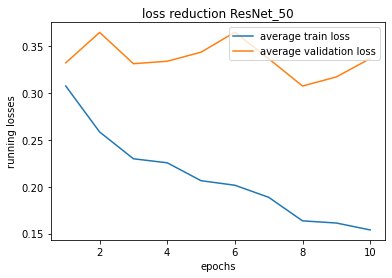

In [20]:
# Set up dataloaders
image_size = (224,224)  # max(450,576)
num_workers = 1
batch_size_train = 10
batch_size_val = 10
batch_size_test = 10
loaders=get_loaders(image_size, batch_size_train, batch_size_val, batch_size_test, num_workers)

# Define parameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_Resnet50.parameters(), lr=0.00001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Train model
n_epochs = 10
print_every = 365
save_path = './models'
model_Resnet50, train_loss, val_loss = train(n_epochs, loaders, model_Resnet50, optimizer, criterion, use_cuda,
                                           'model_Resnet50_fine.pt', is_inception=False)

# Display loss reduction profile
plot_loss('ResNet_50', train_loss, val_loss)


Test Loss: 0.658510

Test Accuracy of melanoma:  86%     (101/117)
Test Accuracy of nevus:  77%     (303/393)
Test Accuracy of seborrheic_keratosis:  100%    (90/90)

Test Accuracy (Overall):                                                82%     (494/600)

getting predictions on all test images:



writing score csv file


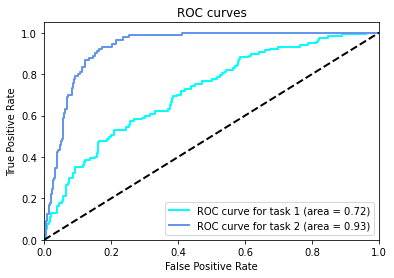

Category 1 Score: 0.717
Category 2 Score: 0.931
Category 3 Score: 0.824


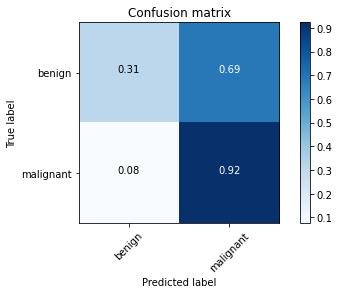

In [21]:
# load the model that got the best validation accuracy
if torch.cuda.is_available():
    model_Resnet50.load_state_dict(torch.load('models/model_Resnet50_fine.pt'))
else:
    model_Resnet50.load_state_dict(torch.load('models/model_Resnet50_fine.pt', map_location=torch.device('cpu')))

num_classes = 3

# Test model
with torch.no_grad():
    test(loaders, model_Resnet50, criterion, use_cuda)
    get_scores(model_Resnet50, (450,576))

Epoch [1/10] Step [365/365]	 Loss: 0.1266	 avg_Loss: 0.1257	 exec_time: 420 s	 train_time:	 0 h 7 m
Epoch [1/10]	 avg_train Loss: 0.1257			 avg_validation Loss: 0.3769	 val_accuracy: 84.00
improved model saved to disk
Epoch [2/10] Step [365/365]	 Loss: 0.4752	 avg_Loss: 0.1319	 exec_time: 415 s	 train_time:	 0 h 14 m
Epoch [2/10]	 avg_train Loss: 0.1319			 avg_validation Loss: 0.2637	 val_accuracy: 88.00
improved model saved to disk
Epoch [3/10] Step [365/365]	 Loss: 0.3847	 avg_Loss: 0.1255	 exec_time: 416 s	 train_time:	 0 h 21 m
Epoch [3/10]	 avg_train Loss: 0.1255			 avg_validation Loss: 0.2791	 val_accuracy: 89.33
Epoch [4/10] Step [365/365]	 Loss: 0.0157	 avg_Loss: 0.1213	 exec_time: 413 s	 train_time:	 0 h 29 m
Epoch [4/10]	 avg_train Loss: 0.1213			 avg_validation Loss: 0.2910	 val_accuracy: 87.33
Epoch [5/10] Step [365/365]	 Loss: 0.0745	 avg_Loss: 0.1202	 exec_time: 419 s	 train_time:	 0 h 36 m
Epoch [5/10]	 avg_train Loss: 0.1202			 avg_validation Loss: 0.3018	 val_accuracy:

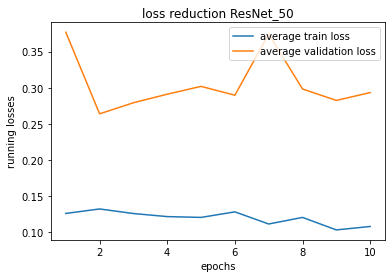

In [24]:
# Set up dataloaders
image_size = (224,224)  # max(450,576)
num_workers = 1
batch_size_train = 10
batch_size_val = 10
batch_size_test = 10
loaders=get_loaders(image_size, batch_size_train, batch_size_val, batch_size_test, num_workers)

# Define parameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_Resnet50.parameters(), lr=0.000001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Train model
n_epochs = 10
print_every = 365
save_path = './models'
model_Resnet50, train_loss, val_loss = train(n_epochs, loaders, model_Resnet50, optimizer, criterion, use_cuda,
                                           'model_Resnet50_superfine.pt', is_inception=False)

# Display loss reduction profile
plot_loss('ResNet_50', train_loss, val_loss)


Test Loss: 0.682891

Test Accuracy of melanoma:  86%     (101/117)
Test Accuracy of nevus:  78%     (305/393)
Test Accuracy of seborrheic_keratosis:  100%    (90/90)

Test Accuracy (Overall):                                                83%     (496/600)

getting predictions on all test images:



writing score csv file


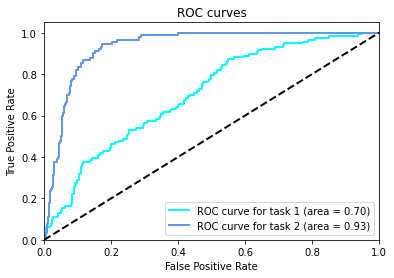

Category 1 Score: 0.703
Category 2 Score: 0.934
Category 3 Score: 0.818


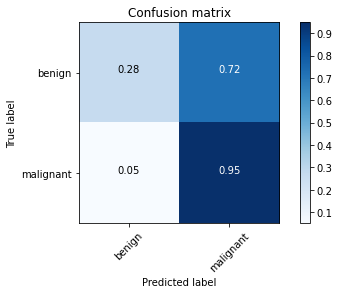

In [25]:
# load the model that got the best validation accuracy
if torch.cuda.is_available():
    model_Resnet50.load_state_dict(torch.load('models/model_Resnet50_superfine.pt'))
else:
    model_Resnet50.load_state_dict(torch.load('models/model_Resnet50_superfine.pt', map_location=torch.device('cpu')))

num_classes = 3

# Test model
with torch.no_grad():
    test(loaders, model_Resnet50, criterion, use_cuda)
    get_scores(model_Resnet50, (450,576))

Epoch [1/5] Step [365/365]	 Loss: 0.0133	 avg_Loss: 0.1221	 exec_time: 411 s	 train_time:	 0 h 6 m
Epoch [1/5]	 avg_train Loss: 0.1221			 avg_validation Loss: 0.3303	 val_accuracy: 86.00
improved model saved to disk
Epoch [2/5] Step [365/365]	 Loss: 0.0148	 avg_Loss: 0.1217	 exec_time: 413 s	 train_time:	 0 h 14 m
Epoch [2/5]	 avg_train Loss: 0.1217			 avg_validation Loss: 0.3083	 val_accuracy: 84.67
improved model saved to disk
Epoch [3/5] Step [365/365]	 Loss: 0.1223	 avg_Loss: 0.1267	 exec_time: 413 s	 train_time:	 0 h 21 m
Epoch [3/5]	 avg_train Loss: 0.1267			 avg_validation Loss: 0.2859	 val_accuracy: 88.67
improved model saved to disk
Epoch [4/5] Step [365/365]	 Loss: 0.0157	 avg_Loss: 0.1182	 exec_time: 412 s	 train_time:	 0 h 28 m
Epoch [4/5]	 avg_train Loss: 0.1182			 avg_validation Loss: 0.3191	 val_accuracy: 85.33
Epoch [5/5] Step [365/365]	 Loss: 0.2664	 avg_Loss: 0.1151	 exec_time: 413 s	 train_time:	 0 h 36 m
Epoch [5/5]	 avg_train Loss: 0.1151			 avg_validation Loss: 0.

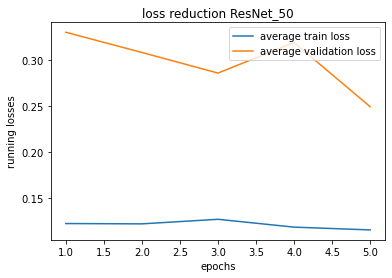

In [26]:
# Set up dataloaders
image_size = (224,224)  # max(450,576)
num_workers = 1
batch_size_train = 10
batch_size_val = 10
batch_size_test = 10
loaders=get_loaders(image_size, batch_size_train, batch_size_val, batch_size_test, num_workers)

# Define parameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_Resnet50.parameters(), lr=0.000001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Train model
n_epochs = 5
print_every = 365
save_path = './models'
model_Resnet50, train_loss, val_loss = train(n_epochs, loaders, model_Resnet50, optimizer, criterion, use_cuda,
                                           'model_Resnet50_superfine2.pt', is_inception=False)

# Display loss reduction profile
plot_loss('ResNet_50', train_loss, val_loss)


Test Loss: 0.682720

Test Accuracy of melanoma:  85%     (100/117)
Test Accuracy of nevus:  79%     (312/393)
Test Accuracy of seborrheic_keratosis:  100%    (90/90)

Test Accuracy (Overall):                                                84%     (502/600)

getting predictions on all test images:



writing score csv file


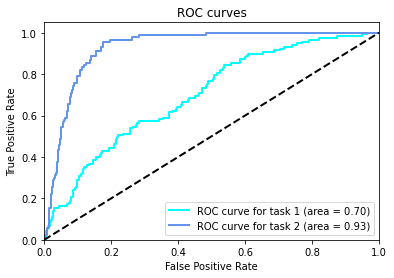

Category 1 Score: 0.699
Category 2 Score: 0.929
Category 3 Score: 0.814


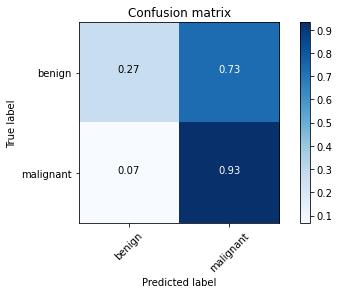

In [27]:
# load the model that got the best validation accuracy
if torch.cuda.is_available():
    model_Resnet50.load_state_dict(torch.load('models/model_Resnet50_superfine2.pt'))
else:
    model_Resnet50.load_state_dict(torch.load('models/model_Resnet50_superfine2.pt', map_location=torch.device('cpu')))

num_classes = 3

# Test model
with torch.no_grad():
    test(loaders, model_Resnet50, criterion, use_cuda)
    get_scores(model_Resnet50, (450,576))

# Try Ensemble approach for classification

In [43]:
def get_predictions_ensemble(model1, model2, model3, input_img_dim=(224,224)):
    
    batch_size_test = 1
    loaders = get_loaders (input_img_dim, batch_size_train, batch_size_val, batch_size_test, num_workers)
    
    model1.eval() # Model predicting Melanoma
    model2.eval() # Model predicting Nevus   - best predicting model
    model3.eval()  # Model predicting Seborreic
    
    # monitor test accuracy
    class_correct = list(0. for i in range(num_classes))
    class_total = list(0. for i in range(num_classes))
    correct = 0

    for data, label in tqdm(loaders['test']):
        
        if use_cuda:
            data = data.cuda()
        
        output1 = model1(data)
        output2 = model2(data)
        output3 = model3(data)
        
        # Select output probabilities for each class
        output1 = torch.nn.functional.softmax(output1, dim=1)
        prob1, pred1 = torch.max(output1, dim=1)
        if pred1 == 0:
            output1 = output1 * 2
            
        output2 = torch.nn.functional.softmax(output2, dim=1)
        prob2, pred2 = torch.max(output2, dim=1)
        if pred2 == 1:
            output2 = output2 * 2
        
        output3 = torch.nn.functional.softmax(output3, dim=1)
        prob3, pred3 = torch.max(output3, dim=1)
        if pred3 == 2:
            output3 = output3 * 2
        
        # convert ensemble probabilities to predicted class
        tot_prob = output1.squeeze()[0] + output2.squeeze()[1] + output3.squeeze()[2]
        prob_melanoma = output1.squeeze()[0] / tot_prob
        prob_nevus = output2.squeeze()[1] / tot_prob
        prob_sebo = output3.squeeze()[2] / tot_prob
        
        prob = np.array([prob_melanoma, prob_nevus, prob_sebo])
        
        prediction = np.argmax(prob)
        
        # calculate test accuracy for each object class
        class_correct[label] += (prediction==label.cpu().detach().numpy().squeeze()).item()
        class_total[label] += 1
        
    for i in range(num_classes):
        if class_total[i] > 0:
            
            print('Test Accuracy of {}:'.format(labels[i]),
              ' {:.0f}%'.format(100 * class_correct[i] / class_total[i]).ljust(8,' '), 
              '({:.0f}/{:.0f})'.format(np.sum(class_correct[i]), np.sum(class_total[i])))
            
        else:
            print('Test Accuracy of {}: N/A (no training examples)'.format(labels[i]))
                      
    print('\nTest Accuracy (Overall):\t {:.0f}%'.format(100. * np.sum(class_correct) / np.sum(class_total)).expandtabs(71),
      '\t({:.0f}/{:.0f})'.format(np.sum(class_correct), np.sum(class_total)).expandtabs(4))

In [44]:
num_classes = 3
## Specify model architecture

#Model 1
model_inception_1 = models.inception_v3(pretrained=True, aux_logits=True)  # Be careful, InceptionV3 expects (299,299) sized images and has auxiliary output
model_inception_1 = model_inception_1.to(device)

model_inception_1.AuxLogits.fc = nn.Linear(768, num_classes)

classifier = nn.Sequential(OrderedDict([ ('fc1', nn.Linear(2048, 1024)),     
                                         ('relu', nn.ReLU()),
                                        ('drop', nn.Dropout(0.1)),
                                         ('fc2', nn.Linear(1024, num_classes)) 
                                         ]))                                              

model_inception_1.fc = classifier


#Model 2
model_inception_2 = models.inception_v3(pretrained=True, aux_logits=True)            
model_inception_2 = model_inception_2.to(device)

model_inception_2.AuxLogits.fc = nn.Linear(768, num_classes)
BasicConv2d = nn.Sequential(OrderedDict([('conv', nn.Conv2d(2048, 192, kernel_size=(1,1), stride=(1,1))),
                                         ('bn', nn.BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True))]))
classifier = nn.Sequential(OrderedDict([ ('fc1', nn.Linear(2048, 512)),     
                                         ('relu', nn.ReLU()),
                                        ('drop', nn.Dropout(0.4)),
                                         ('fc2', nn.Linear(512, num_classes)) 
                                         ]))                                            
model_inception_2.Mixed_7c.branch_pool = BasicConv2d
model_inception_2.fc = classifier

#Model 3
model_Resnet50= models.resnet50(pretrained = True)
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 1024)),
                          ('Elu', nn.ELU()),
                          ('Dropout',nn.Dropout(0.05)),
                          ('fc2', nn.Linear(1024, 3)),
                          ]))
model_Resnet50.fc = classifier


model1 = model_inception_1
model2 = model_inception_1
model3 = model_Resnet50

# load the model that got the best validation accuracy
if torch.cuda.is_available():
    model1 = model1.cuda()
    model2 = model2.cuda()
    model3 = model3.cuda()
    
    model1.load_state_dict(torch.load('models/model_inception_3.pt'))
    model2.load_state_dict(torch.load('models/model_inception_3.pt'))
    model3.load_state_dict(torch.load('models/model_Resnet50_fine.pt'))
    
else:
    model1.load_state_dict(torch.load('models/model_inception_3.pt', map_location=torch.device('cpu')))
    model2.load_state_dict(torch.load('models/model_inception_3.pt', map_location=torch.device('cpu')))
    model3.load_state_dict(torch.load('models/model_Resnet50_fine.pt', map_location=torch.device('cpu')))


In [45]:
get_predictions_ensemble(model1, model2, model3, input_img_dim=(224,224))


Test Accuracy of melanoma:  83%     (97/117)
Test Accuracy of nevus:  72%     (283/393)
Test Accuracy of seborrheic_keratosis:  99%     (89/90)

Test Accuracy (Overall):                                                78%     (469/600)
